# PCA with MNIST

--------------------------------------------------------------------------------------------------------------

>Please download the four MNIST data files from [this website](http://yann.lecun.com/exdb/mnist/) and uncompress the files if necessary.

--------------------------------------------------------------------------------------------------------------

### Import necessary libraries

In [6]:
from tensorflow.keras.datasets import mnist

import struct
from array import array
import numpy as np
import matplotlib.pyplot as plt

### Function definitions

In [7]:
# load the mnist data base
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

>Replace the code below with your own MNIST path. You may also need to fix the pathway in load_mnist if necessary.

In [8]:
mnist_data_dir=r'/Users/stephanieshin/Desktop/Active Learning MNIST/MNIST data'

In [9]:
# Function to load the MNIST data
def load_mnist(dataset="training", digits=range(10), mnist_data_dir=mnist_data_dir):
    #Check training/testing specification. Must be "training" (default) or "testing"
    if dataset == "training":
        fname_digits = mnist_data_dir + '/' + 'train-images-idx3-ubyte'
        fname_labels = mnist_data_dir + '/' + 'train-labels-idx1-ubyte'
    elif dataset == "testing":
        fname_digits = mnist_data_dir + '/' + 't10k-images-idx3-ubyte'
        fname_labels = mnist_data_dir + '/' + 't10k-labels-idx1-ubyte'
    else:
        raise ValueError("dataset must be 'testing' or 'training'")
    
    #Import digits data
    digitsfileobject = open(fname_digits, 'rb') # rb --> read bytes
    magic_nr, size, rows, cols = struct.unpack(">IIII", digitsfileobject.read(16))
    digitsdata = array("B", digitsfileobject.read())
    digitsfileobject.close()

    #Import label data
    labelsfileobject = open(fname_labels, 'rb')
    magic_nr, size = struct.unpack(">II", labelsfileobject.read(8))
    labelsdata = array("B",labelsfileobject.read())
    labelsfileobject.close()
    
    #Find indices of selected digits
    indices = [k for k in range(size) if labelsdata[k] in digits]
    N = len(indices)
    
    #Create empty arrays for X and y
    x = np.zeros((N, rows*cols), dtype=np.uint8)
    y = np.zeros((N, ), dtype=np.uint8)
    
    #Fill x from digitsdata
    #Fill y from labelsdata
    for i in range(N):
        x[i] = digitsdata[indices[i]*rows*cols:(indices[i]+1)*rows*cols]
        y[i] = labelsdata[indices[i]]
    
    return x,y

In [10]:
# Function to reformat feature vectors and show them as images
# def vectortoimg(*args,width=28,size=1,show=True):
#     """
#     Example: vectortoimg(random.random(784)) or vectortoimg(random.random(784),arange(784))
#     """
#     n = len(args)
#     fig = plt.figure()
#     for i,arg in enumerate(args):
#         plt.subplot(1, n, i+1)
#         plt.imshow(arg.reshape(width, width), interpolation='None', cmap='gray')
#         plt.axis('off')
#     fig.tight_layout(pad=0)
#     fig.set_size_inches(w=n*size,h=size)
#     if show:
#         plt.show()

### Display the data

In [11]:
train_images, train_labels = load_mnist(dataset="training")

>Some aspects of our data...

In [12]:
# 60000 train images
print(train_images.shape)

# 60000 train labels
# print(len(train_labels))

# each label is a number from 0 to 9
print(train_labels) 

# # 10000 test images
# print(test_images.shape)

# # 10000 test labels from 0 to 9
# print(test_labels)

print(train_labels[50])
train_images[50]


(60000, 784)
[5 0 4 ... 5 6 8]
3


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  12,  56, 140, 126, 175, 200,  96,   2,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  35, 166, 238, 254, 246, 242, 253, 246,
       254,  67,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 184, 182, 146, 127,  7

>Displaying 100 digits...

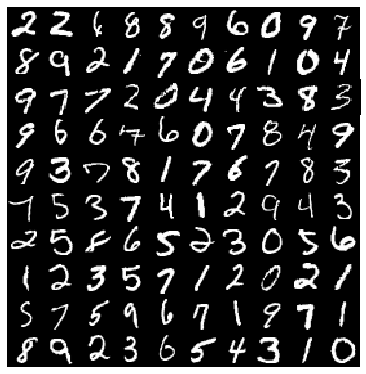

In [13]:
fig = plt.figure()
nrows = 10
ncols = 10
size = 0.5
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1) # rows, columns, index within the figure
        plt.imshow(train_images[np.random.randint(len(train_labels))].reshape(28, 28),interpolation='None', cmap='gray')
        plt.axis('off')

fig.tight_layout(pad=0) # Remove padding between each digit that's displayed
fig.set_size_inches(w=ncols*size,h=nrows*size)
plt.show()

## Principle Component Analysis (PCA)

>Here, I have created a function to perform a 2D PCA on any 2 digits of your choice.

In [14]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [15]:
def PCA_2D(num1, num2):
    # LOAD YOUR TRAINING DATA WITH THE DESIRED DIGITS
    x_train, y_train = load_mnist(dataset="training",digits=[num1, num2])
    random_index = np.random.randint(len(y_train)) # Index of randomly selected feature vector

    # STANDARDIZE THE DATA
    x_transform = StandardScaler().fit_transform(x_train)
    #x_transform = x_train
    y_train = y_train.astype('object')
    
    # BEGIN PCA
    pca = PCA(n_components=2)
    pcomponents = pca.fit_transform(x_transform)
    principal_df = pd.DataFrame(data = pcomponents
                 , columns = ['Principal Component 1', 'Principal Component 2'])
    labels = pd.DataFrame(data = y_train
                 , columns = ['Label'])
    
    # CONCATENATE THE DIGIT ARRAYS WITH THE LABELS INTO THE FINAL PCA
    final_pca = pd.concat([principal_df, labels], axis = 1)

    # CREATE THE PCA SCATTERPLOT
#     fig = plt.figure(figsize = (10,10))
#     ax = fig.add_subplot(1,1,1) 
    
#     title = '2D PCA with Digits ' + str(num1) + ' and ' + str(num2)
    
#     ax.set_xlabel('Principal Component 1', fontsize = 15)
#     ax.set_ylabel('Principal Component 2', fontsize = 15)
#     ax.set_title(title, fontsize = 15)

#     labels = [num1, num2]
#     colors = ['r', 'b']
#     for label, color in zip(labels, colors):
#         indicesToKeep = final_pca['Label'] == label
#         ax.scatter(final_pca.loc[indicesToKeep,'Principal Component 1']
#                    , final_pca.loc[indicesToKeep,'Principal Component 2']
#                    , c = color
#                    , s = 15)
#     ax.legend(labels)
#     ax.grid()
    
    return final_pca

### Build the linear classifier on the PCA with SVM

In [28]:
from pandas import to_numeric
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def lin_classifier(num1, num2, pca):
    y_train = to_numeric(pca['Label'], errors='coerce')
    x_train = np.vstack((pca['Principal Component 1'], pca['Principal Component 2'])).T

    lr = LogisticRegression()
    lr = lr.fit(x_train, y_train)
    
    xx, yy = np.mgrid[-25:25:.01, -25:25:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = lr.predict_proba(grid)[:, 1].reshape(xx.shape)
    
    # CREATE THE PCA SCATTERPLOT
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    
    title = '2D PCA with Digits ' + str(num1) + ' and ' + str(num2) + ' with Linear Classifier'
    
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 15)

    labels = [num1, num2]
    colors = ['r', 'b']
    for label, color in zip(labels, colors):
        indicesToKeep = pca['Label'] == label
        ax.scatter(pca.loc[indicesToKeep,'Principal Component 1']
                   , pca.loc[indicesToKeep,'Principal Component 2']
                   , c = color
                   , s = 15)
    ax.legend(labels)
    ax.grid()

    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    
    #print("Coefficients:", lr.coef_)
    #print("Intercept:", lr.intercept_)
    
    y_2 = []
    for i in y_train:
        if i == num1:
            y_2.append(0)
        else:
            y_2.append(1)
            
    x_test, y_test = load_mnist(dataset="testing",digits=[num1, num2])
    y_test = to_numeric(pca['Label'], errors='coerce')
    x_test = np.vstack((pca['Principal Component 1'], pca['Principal Component 2'])).T
    
    lr.predict(x_test)
    print("Score for", num1, "and", num2, "=", lr.score(x_test, y_test))

### Run 2D PCA on select digits with Linear Classifier

Score for 2 and 3 = 0.9293572669368848

Score for 7 and 4 = 0.9031964978937804


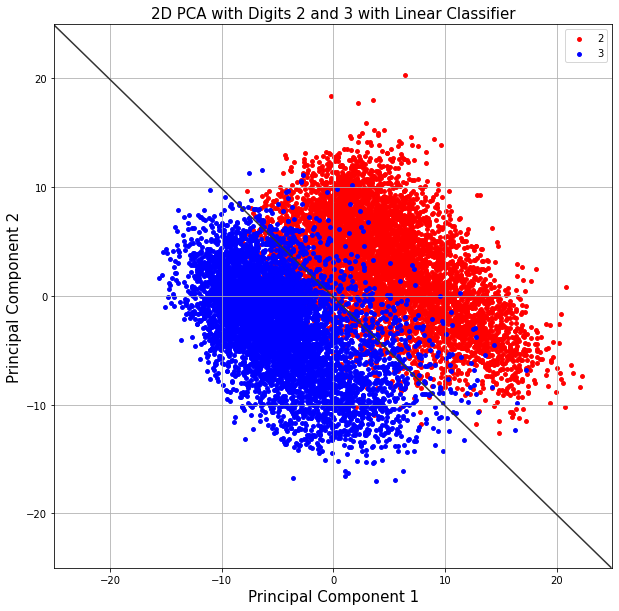

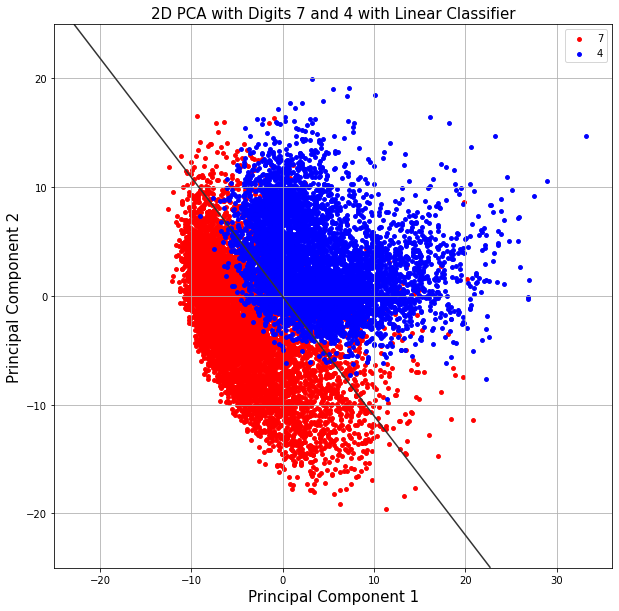

In [31]:
# num1 = int(input("Enter first digit: "))
# num2 = int(input("Enter second digit: "))

# this example seems to be fine
pca = PCA_2D(2, 3)
lin_classifier(2, 3, pca)

print()

#this example has an extremely low accuracy score
pca = PCA_2D(7, 4)
lin_classifier(7, 4, pca)